#### How to run the Jupyter Notebook File
1. Open the Jupyter Notebook File in either a Local Machine (must have Jupyter Notebook Installed), or online (using [Google Colab](https://colab.research.google.com))
2. Place the required files on the same location as the Jupyter Notebook File<br>
&emsp; List of Required Files:
    * &emsp;Sentinel Satellite Images (`sentinel_2_l1c_toImages`)
3. Run the Jupyter Notebook by running on each cell, or running all at once<br>
To run a cell: Click on a cell and press `Shift + Enter `. You can press `Shift + Enter` again to run the cell next to it.<br>
To run all cells: Click the `Run All` option on Jupyter Notebook, or Go to `Runtime > Run All` on Google Colab (Shortcut is `CTRL + F9`)<br>
\*\***Note**\*\*<br>
Some cell may install additional module/s for the Jupyter Notebook to run properly. Please allow the Jupyter Notebook to install those modules
</ol>

In [ ]:
"""
Installs all required modules (for Local Machines only)
"""
!pip install pandas numpy tensorflow matplotlib opencv-python

In [1]:
# Import the necessary libraries
import os
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
from cv2 import imread, cvtColor, COLOR_BGR2RGB
# # Mount your Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling3D, ConvLSTM2D, BatchNormalization, Dropout
import matplotlib.pyplot as plt


In [2]:
# Set the path to the folder containing the jpg files.
folder_path = 'sentinel_2_l1c_toImages'

# Select all the jpg files in the folder.
jpg_files = []
for file in os.listdir(folder_path):
    if file.endswith(".jpg"):
        jpg_files.append(os.path.join(folder_path, file))

dates = [date.fromisoformat("2015-10-01") + relativedelta(months=m) for m in range(0, jpg_files.__len__())]
# Flatten the jpg files.
flattened_jpg_files = []
for jpg_file in jpg_files:
    image = imread(jpg_file)
    image = cvtColor(image, COLOR_BGR2RGB)
    image = tf.image.resize(image, (64, 64))
    flattened_jpg_files.append(image)
NDVI_df = pd.DataFrame({"date": dates, "image":flattened_jpg_files}).set_index("date")
NDVI_df


,image
date,
2015-10-01,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf..."
2015-11-01,"(((tf.Tensor(0.0, shape=(), dtype=float32), tf..."
2015-12-01,"(((tf.Tensor(0.5, shape=(), dtype=float32), tf..."
2016-01-01,"(((tf.Tensor(122.5, shape=(), dtype=float32), ..."
2016-02-01,"(((tf.Tensor(0.5, shape=(), dtype=float32), tf..."
...,...
2023-04-01,"(((tf.Tensor(0.25, shape=(), dtype=float32), t..."
2023-05-01,"(((tf.Tensor(0.25, shape=(), dtype=float32), t..."
2023-06-01,"(((tf.Tensor(245.5, shape=(), dtype=float32), ..."


In [3]:
training_set = NDVI_df[:int(0.8 * len(NDVI_df))]
test_set = NDVI_df[int(0.8 * len(NDVI_df)):]

In [4]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = []
        for j in range(LOOK_BACK):
            v.append(X[i + j])
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 3
X_train, y_train = create_dataset(training_set['image'],LOOK_BACK)
X_test, y_test = create_dataset(test_set['image'],LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (73, 3, 64, 64, 3)
y_train.shape:  (73, 64, 64, 3)
X_test.shape:  (16, 3, 64, 64, 3)
y_test.shape:  (16, 64, 64, 3)


In [9]:
# Train an LSTM model on the training set.
model = Sequential()
model.add(ConvLSTM2D(32, (1, 1), activation='tanh', return_sequences=True, input_shape=(LOOK_BACK, X_train.shape[2], X_train.shape[3], 3), data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling3D((1, 1, 1), padding='same'))
model.add(ConvLSTM2D(32, (1, 1), activation='tanh', return_sequences=True))
model.add(BatchNormalization())
model.add(MaxPooling3D((3, 1, 1), padding='same'))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense((3)))
model.compile(loss='mse', optimizer='adam')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 3, 64, 64, 32)     4608      
                                                                 
 batch_normalization_4 (Batc  (None, 3, 64, 64, 32)    128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 64, 64, 32)    0         
 3D)                                                             
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 3, 64, 64, 32)     8320      
                                                                 
 batch_normalization_5 (Batc  (None, 3, 64, 64, 32)    128       
 hNormalization)                                                 
                                                      

In [10]:
history = model.fit(X_train, y_train, epochs=1000, batch_size= 25)

Epoch 1/1000


3/3 [==============================] - 6s 298ms/step - loss: 10914.7959
Epoch 2/1000
3/3 [==============================] - 1s 204ms/step - loss: 10527.7461
Epoch 3/1000
3/3 [==============================] - 1s 200ms/step - loss: 10066.4316
Epoch 4/1000
3/3 [==============================] - 1s 212ms/step - loss: 9429.0107
Epoch 5/1000
3/3 [==============================] - 1s 204ms/step - loss: 8664.5713
Epoch 6/1000
3/3 [==============================] - 1s 207ms/step - loss: 7762.9844
Epoch 7/1000
3/3 [==============================] - 1s 202ms/step - loss: 6816.1543
Epoch 8/1000
3/3 [==============================] - 1s 204ms/step - loss: 5897.0376
Epoch 9/1000
3/3 [==============================] - 1s 205ms/step - loss: 5225.0293
Epoch 10/1000
3/3 [==============================] - 1s 204ms/step - loss: 5168.2158
Epoch 11/1000
3/3 [==============================] - 1s 203ms/step - loss: 5296.9131
Epoch 12/1000
3/3 [==============================] - 1s 199ms/step - loss: 5308.3247

In [12]:
# Evaluate the LSTM model on the test set.
test_loss = model.evaluate(X_test, y_test)
print("Test loss:", test_loss);

1/1 [==============================] - 1s 1s/step - loss: 4286.9258
Test loss: 4286.92578125


In [13]:
test_result = model.predict(X_test)

1/1 [==============================] - 1s 768ms/step


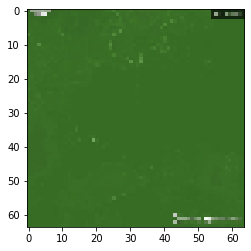

In [14]:
plt.imshow(test_result[-1][-1].astype(np.uint8))